# Table of Contents
 <p><div class="lev1"><a href="#Reproduce-Torch-gradient-descent">Reproduce Torch gradient descent</a></div><div class="lev2"><a href="#Convert-MNIST-csv-data-to-numpy">Convert MNIST csv data to numpy</a></div><div class="lev2"><a href="#Reproduce-loss-on-first-example">Reproduce loss on first example</a></div><div class="lev2"><a href="#Reproduce-gradient-on-first-example">Reproduce gradient on first example</a></div><div class="lev3"><a href="#Get-gradients-in-TensorFlow">Get gradients in TensorFlow</a></div><div class="lev2"><a href="#Get-gradients/parameters-from-Lua">Get gradients/parameters from Lua</a></div><div class="lev2"><a href="#Reproduce-MNIST-sgd">Reproduce MNIST sgd</a></div><div class="lev3"><a href="#Feed-lua-params-back-into-TensorFlow">Feed lua params back into TensorFlow</a></div><div class="lev1"><a href="#Scratch">Scratch</a></div><div class="lev2"><a href="#Tensor-shape-question">Tensor shape question</a></div>

In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [16]:
import tensorflow as tf
import numpy as np
from tensorflow.python.client import device_lib
import tensorflow.contrib.immediate as immediate

device_names = [d.name for d in device_lib.list_local_devices()]
print device_names

[u'/cpu:0']


ImportError: No module named PIL

README.md           lbfgs-macbook.ipynb mnist4
data                logs                mnist4.zip
dataset-mnist.lua   mnist.t7            port.lua


# Reproduce Torch gradient descent

## Convert MNIST csv data to numpy

In [4]:
data = np.loadtxt("mnist.t7/test_32x32.t7.csv.data", dtype=np.uint8).reshape(10000, 32, 32)
np.save("mnist.t7/test_32x32.npy", data)

In [6]:
data = np.loadtxt("mnist.t7/train_32x32.t7.csv.data", dtype=np.uint8).reshape(60000, 32, 32)
np.save("mnist.t7/train_32x32.npy", data)

In [8]:
data = np.loadtxt("mnist.t7/train_32x32.t7.csv.labels", dtype=np.uint8)
np.save("mnist.t7/train_labels.npy", data)

In [9]:
data = np.loadtxt("mnist.t7/test_32x32.t7.csv.labels", dtype=np.uint8)
np.save("mnist.t7/test_labels.npy", data)

## Reproduce loss on first example

In [11]:
train_data = np.load("mnist.t7/train_32x32.npy")

In [47]:
train_labels = np.load("mnist.t7/train_labels.npy")

In [32]:
env = immediate.Env(tf)
tfi = env.tf

In [74]:
i = 0
W = tfi.ones((10, 1024), dtype=tf.float32)
b = tfi.ones((10, 1), dtype=tf.float32)
x = env.numpy_to_itensor(train_data[i], dtype=tf.float32)
x_flat = tfi.reshape(x, (1024, 1))
logits = tfi.matmul(W, x_flat)+b
targets = tfi.one_hot(train_labels[i]-1, 10)  # Lua labels are off-by-one
targets = tfi.reshape(targets, (1, 10))
logits = tfi.reshape(logits, (1, 10))
cross_entropy = tfi.nn.softmax_cross_entropy_with_logits(logits, targets)

In [75]:
cross_entropy

ITensor([ 2.30258512], dtype=float32)

## Reproduce gradient on first example

In [77]:
lua_grad = np.loadtxt("first_grad.csv", dtype=np.float32)

In [125]:
tfi.reduce_sum(lua_grad)

ITensor(0.0186698, dtype=float32)

In [129]:
lua_grad.shape

(10250,)

In [133]:
lua_grad[-10:]

array([ 0.1       ,  0.1       ,  0.1       ,  0.1       ,  0.1       ,
       -0.89999998,  0.1       ,  0.1       ,  0.1       ,  0.1       ], dtype=float32)

### Get gradients in TensorFlow

In [153]:
dtype = tf.float64
W = tf.Variable(tf.ones_initializer((10, 1024), dtype=dtype))
b = tf.Variable(tf.ones_initializer((10, 1), dtype=dtype))
x = tf.constant(train_data[i], dtype=dtype)
x_flat = tf.reshape(x, (1024, 1))
logits = tf.matmul(W, x_flat)+b
targets = tf.one_hot(train_labels[i]-1, 10, dtype=dtype)  # Lua labels are off-by-one
targets = tf.reshape(targets, (1, 10))
logits = tf.reshape(logits, (1, 10))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, targets)
gradients = tf.gradients(cross_entropy, [W, b])

In [157]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [156]:
sess.run(gradients[1])

array([[ 0.1],
       [ 0.1],
       [ 0.1],
       [ 0.1],
       [ 0.1],
       [ 0.1],
       [ 0.1],
       [-0.9],
       [ 0.1],
       [ 0.1]])

In [149]:
sess.run(targets)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]], dtype=float32)

In [150]:
train_labels[0]

6

## Get gradients/parameters from Lua

In [481]:
lua_grads = []
lua_params = []
lua_fvals = []
for i in range(1, 1000):
    grad_fname = "stepdata/grad-"+str(i)
    param_fname = "stepdata/params-"+str(i)
    fval_fname = "stepdata/fval-"+str(i)
    if not os.path.exists(grad_fname) or not os.path.exists(param_fname):
        break
    lua_grads.append(np.loadtxt(grad_fname))
    lua_params.append(np.loadtxt(param_fname))
    lua_fvals.append(np.loadtxt(fval_fname))

In [482]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

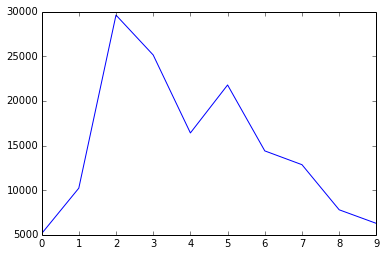

In [483]:
plt.plot(lua_fvals)

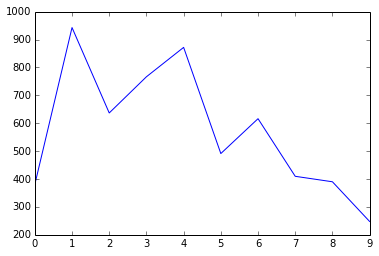

In [484]:
plt.plot([np.linalg.norm(x) for x in lua_grads])

## Reproduce MNIST sgd

In [440]:
train_data = np.load("mnist.t7/train_32x32.npy")
train_data_flat = train_data.reshape((-1, 1024))
train_labels = np.load("mnist.t7/train_labels.npy")
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [459]:
def concat_flatten(tensors):
    """Flattens tensors, concats them"""
    flat_tensors = []
    for tensor in tensors:
        flat_tensors.append(tf.reshape(tensor, [-1]))
    return tf.concat(0, flat_tensors)

In [552]:
dtype = tf.float64
batchSize = 100
learningRate = 0.1

tf.reset_default_graph()

W = tf.Variable(tf.ones_initializer((1024, 10), dtype=dtype))
b = tf.Variable(tf.ones_initializer((1, 10), dtype=dtype))
x = tf.Variable(tf.zeros_initializer((batchSize, 1024), dtype=dtype))
targets = tf.Variable(tf.zeros_initializer((batchSize, 10), dtype=dtype))
logits = tf.matmul(x, W) + b

# cross entropy expects batch dimension to be first, transpose inputs
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, targets)
cross_entropy_loss = tf.reduce_mean(cross_entropy)
Wnorm = tf.reduce_sum(tf.square(W))
bnorm = tf.reduce_sum(tf.square(b))
loss = cross_entropy_loss + (bnorm + Wnorm)/2

# grads = tf.gradients(loss, [W, b])
opt = tf.train.GradientDescentOptimizer(learning_rate=learningRate)
grads_and_vars = opt.compute_gradients(loss, [W, b])
train_step = opt.apply_gradients(grads_and_vars)

W_grad = grads_and_vars[0][0]
b_grad = grads_and_vars[1][0]
flat_grad = concat_flatten([tf.transpose(W_grad), b_grad])
# flat_grad = concat_flatten([grad_and_var[0] for grad_and_var in grads_and_vars])
flat_params = concat_flatten([W, b])

# initialize x and targets
x_placeholder = tf.placeholder(dtype=dtype)
x_init = x.assign(x_placeholder)

# initialize labels
labels_placeholder = tf.placeholder(shape=(batchSize), dtype=tf.int32)
labels_onehot = tf.one_hot(labels_placeholder - 1, 10, dtype=dtype)  # Lua labels are off-by-one
targets_init = targets.assign(labels_onehot)

sess = tf.InteractiveSession()
sess.run(x_init, feed_dict={x_placeholder:train_data_flat[:batchSize]})
sess.run(targets_init, feed_dict={labels_placeholder: train_labels[:batchSize]})
sess.run([W.initializer, b.initializer])
print(sess.run(loss))

5127.30258509


Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x12e7d31d0>> ignored


In [553]:
tf_grads = []
tf_params = []
tf_fvals = []
for i in range(10):
    tf_grads.append(sess.run(flat_grad))
    tf_params.append(sess.run(flat_params))
    tf_fvals.append(sess.run(loss))
    print(tf_fvals[-1])
    sess.run(train_step)

5127.30258509
10222.2878245
29610.151198
25141.4119371
16409.1374003
21781.9665362
14398.5814516
12851.5786807
7800.24671143
6276.07440723


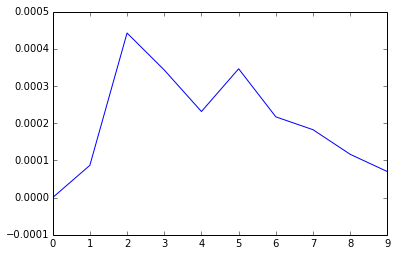

In [543]:
tf_fvals_np = np.array(tf_fvals)
lua_fvals_np = np.array(lua_fvals)
plt.plot(tf_fvals_np - lua_fvals_np)

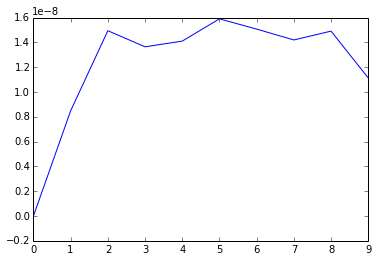

In [544]:
plt.plot((tf_fvals_np - lua_fvals_np)/lua_fvals_np)

### Feed lua params back into TensorFlow

Get the values from Lua, feed them into TensorFlow to get updated grad value

In [577]:
iternum = 1
# convert lua_W from column major to row major
lua_W_flat = lua_params[iternum][:-10]
lua_W = lua_W_flat.reshape((10, 1024))
tf_W = lua_W.T
lua_b = lua_params[iternum][-10:]
tf_b = lua_b.reshape((1, -1))

In [578]:
sess.run(loss, feed_dict={W: tf_W, b: tf_b})

10222.287737750139

In [579]:
lua_fvals[1]

array(10222.28773775)

# Scratch

## Tensor shape question

In [449]:
batch_size = tf.shape(tf.ones((10,10)))
print(tf.zeros((batch_size, 128)).get_shape())

ValueError: Shapes (2,) and () are not compatible

In [452]:
batch_size=tf.shape(tf.ones((10,10)))[0]

In [454]:
batch_size

<tf.Tensor 'Squeeze_1:0' shape=() dtype=int32>

In [443]:
print(tf.zeros((batch_size, 128)).get_shape())

(100, 128)


In [457]:
asdf=tf.Variable??

In [ ]:
asdf=tf.Variable

In [453]:
print(tf.zeros((batch_size, 128)).get_shape())

(?, ?)


In [27]:
import tensorflow as tf
nInputs = 6
nUnitsLayer1 = 3
weights = tf.Variable(tf.truncated_normal([nInputs, nUnitsLayer1]))
biases= tf.Variable(tf.zeros(nUnitsLayer1))

print 'nInputs', nInputs
print 'nUnitsLayer1', nUnitsLayer1
print 'weights shape', tf.shape(weights)
print 'biases shape', tf.shape(biases)

init = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init)
    print 'weights'
    print (weights.eval())
    print 'biases'
    print (biases.eval())


nInputs 6
nUnitsLayer1 3
weights shape Tensor("Shape:0", shape=(2,), dtype=int32)
biases shape Tensor("Shape_1:0", shape=(1,), dtype=int32)
weights
[[-0.42564794  1.32690036 -0.57812071]
 [ 1.3026278  -1.29796839 -1.02938724]
 [ 0.19238499  1.10781586 -0.24808854]
 [-0.60994369 -0.30048054  0.5742262 ]
 [ 0.13138418 -0.60150367  0.44378978]
 [ 0.42674765 -0.44903693  0.32681581]]
biases
[ 0.  0.  0.]


In [28]:
weights.get_shape()

TensorShape([Dimension(6), Dimension(3)])

In [29]:
weights

In [31]:
tf.shape(weights).get_shape

TensorShape([Dimension(2)])

In [163]:
tf.group(tf.constant(1))

In [164]:
stf.nn.top_k([1,2,3])

TopKV2(values=<tf.Tensor 'TopKV2:0' shape=(1,) dtype=int32>, indices=<tf.Tensor 'TopKV2:1' shape=(1,) dtype=int32>)

In [166]:
tf.split(0, 2, [1,2])

[<tf.Tensor 'split:0' shape=(1,) dtype=int32>,
 <tf.Tensor 'split:1' shape=(1,) dtype=int32>]

In [168]:
tf.reset_default_graph()
sess.run(tf.nn.top_k([1,2,3]))

ValueError: Fetch argument <tf.Tensor 'TopKV2:0' shape=(1,) dtype=int32> of <tf.Tensor 'TopKV2:0' shape=(1,) dtype=int32> cannot be interpreted as a Tensor. (Tensor Tensor("TopKV2:0", shape=(1,), dtype=int32) is not an element of this graph.)

In [176]:
tf.reset_default_graph()
op = tf.nn.top_k([1,2,3])
sess = tf.Session()

In [177]:
tf.get_default_graph().as_graph_def()

node {
  name: "TopKV2/input"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
          dim {
            size: 3
          }
        }
        tensor_content: "\001\000\000\000\002\000\000\000\003\000\000\000"
      }
    }
  }
}
node {
  name: "TopKV2/k"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: 1
      }
    }
  }
}
node {
  name: "TopKV2"
  op: "TopKV2"
  input: "TopKV2/input"
  input: "TopKV2/k"
  attr {
    key: "T"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "sorted"
    value {
      b: true
    }
  }
}
versions {
  producer: 10
}

In [179]:
sess.run(["TopKV2:0"])

[array([3], dtype=int32)]

In [181]:
tf.reset_default_graph()
op = tf.split(0, 2, [1,2])
sess = tf.Session()

In [182]:
tf.get_default_graph().as_graph_def()

node {
  name: "split/split_dim"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: 0
      }
    }
  }
}
node {
  name: "split/value"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
          dim {
            size: 2
          }
        }
        tensor_content: "\001\000\000\000\002\000\000\000"
      }
    }
  }
}
node {
  name: "split"
  op: "Split"
  input: "split/split_dim"
  input: "split/value"
  attr {
    key: "T"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "num_split"
    value {
      i: 2
    }
  }
}
versions {
  producer: 10
}

In [184]:
sess.run("split:1")

array([2], dtype=int32)

In [185]:
op

[<tf.Tensor 'split:0' shape=(1,) dtype=int32>,
 <tf.Tensor 'split:1' shape=(1,) dtype=int32>]

In [193]:
tf.reset_default_graph()
op = tf.nn.top_k([1,2,3])
sess = tf.InteractiveSession()
sess.run(tf.nn.top_k([1,2,3]))

[array([3], dtype=int32), array([2], dtype=int32)]

In [197]:
op[0]

<tf.Tensor 'TopKV2:0' shape=(1,) dtype=int32>

In [205]:
op.values

<tf.Tensor 'TopKV2:0' shape=(1,) dtype=int32>

In [206]:
op = tf.split(0,3, [1,2,3])

In [208]:
tf.get_default_graph().as_graph_def()

node {
  name: "TopKV2/input"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
          dim {
            size: 3
          }
        }
        tensor_content: "\001\000\000\000\002\000\000\000\003\000\000\000"
      }
    }
  }
}
node {
  name: "TopKV2/k"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: 1
      }
    }
  }
}
node {
  name: "TopKV2"
  op: "TopKV2"
  input: "TopKV2/input"
  input: "TopKV2/k"
  attr {
    key: "T"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "sorted"
    value {
      b: true
    }
  }
}
node {
  name: "TopKV2_1/input"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tens

In [213]:
tf.reset_default_graph()
a = tf.Variable(tf.ones_initializer((3,3)))
init_op = tf.initialize_all_variables()
sess = tf.InteractiveSession()
sess.run(init_op)
print(tf.get_default_graph().as_graph_def())
print sess.run(["Variable:0"])

node {
  name: "ones"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 3
          }
          dim {
            size: 3
          }
        }
        float_val: 1.0
      }
    }
  }
}
node {
  name: "Variable"
  op: "Variable"
  attr {
    key: "container"
    value {
      s: ""
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: 3
        }
        dim {
          size: 3
        }
      }
    }
  }
  attr {
    key: "shared_name"
    value {
      s: ""
    }
  }
}
node {
  name: "Variable/Assign"
  op: "Assign"
  input: "Variable"
  input: "ones"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@Variable"
      }
    }
  }
  

In [215]:
print sess.run(["Variable:0"])

[array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]], dtype=float32)]


In [216]:
tf.reset_default_graph()
tf.constant(1)
print(tf.get_default_graph().as_graph_def())


node {
  name: "Const"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: 1
      }
    }
  }
}
versions {
  producer: 10
}



In [219]:
    tf.reset_default_graph()
    value = tf.constant(1)
    print(tf.get_default_graph().as_graph_def())
    sess = tf.InteractiveSession()


node {
  name: "Const"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_INT32
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT32
        tensor_shape {
        }
        int_val: 1
      }
    }
  }
}
versions {
  producer: 10
}



In [222]:
sess.run("Const:0")

1

In [232]:
    tf.reset_default_graph()
    value = tf.Variable(tf.ones_initializer(()))
    value2 = value+3
    print(tf.get_default_graph().as_graph_def())
    sess = tf.InteractiveSession()
    sess.run(tf.initialize_all_variables())


node {
  name: "ones"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
        }
        float_val: 1.0
      }
    }
  }
}
node {
  name: "Variable"
  op: "Variable"
  attr {
    key: "container"
    value {
      s: ""
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
  attr {
    key: "shared_name"
    value {
      s: ""
    }
  }
}
node {
  name: "Variable/Assign"
  op: "Assign"
  input: "Variable"
  input: "ones"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@Variable"
      }
    }
  }
  attr {
    key: "use_locking"
    value {
      b: true
    }
  }
  attr {
    key: "validate_shape"
    value {
      b: true
    }
  }
}
node {
  name: "Variable/read"
  op: "Ide

In [227]:
type(value)

tensorflow.python.ops.variables.Variable

In [228]:
value.name

u'Variable:0'

In [233]:
sess.run("Variable:0")

1.0

In [236]:
    tf.reset_default_graph()
    value = tf.placeholder(tf.uint8)
    print(tf.get_default_graph().as_graph_def())
    sess = tf.InteractiveSession()
    sess.run(tf.identity(value), feed_dict={"Placeholder:0":2})


node {
  name: "Placeholder"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_UINT8
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
}
versions {
  producer: 10
}



Exception AssertionError: AssertionError("Nesting violated for default stack of <type 'weakref'> objects",) in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x12aadfb90>> ignored


2

In [235]:
value

<tf.Tensor 'Placeholder:0' shape=<unknown> dtype=uint8>

In [ ]:
feed_dict={"Placeholder:0":2}